# Datatonic Data Project - Ginference - Engagement Inference for Trending Youtube Videos - EDA

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

## Loading and Preprocessing <a id="2"></a>

In [2]:
df_gb = pd.read_csv('GBvideos.csv')
df_us = pd.read_csv('USvideos.csv')

In [3]:
# concatenate GB and US dataframes
df = pd.concat([df_gb, df_us])
df = df.drop_duplicates(subset = ['video_id', 'trending_date'])

In [4]:
# transform dates to datetime forward
df['trending_date'] = pd.to_datetime(df['trending_date'], format='%y.%d.%m')
df['publish_time'] = pd.to_datetime(df['publish_time'], format='%Y-%m-%dT%H:%M:%S.%fZ')

## Exploratory Analysis

How does the views change over the time trending? Whilst it's not easy to see from the messy graph, it seems the growth rate doesn't change much. Some videos are being viewed at a rate that's higher.

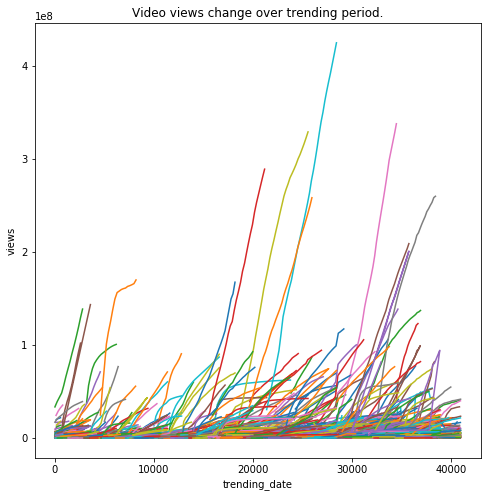

In [5]:
fig, ax = plt.subplots(figsize=(10,10))

grouped = df.groupby('video_id')
grouped['views'].plot(figsize=(8,8))
ax.set(xlabel="trending_date", ylabel="views")
plt.title("Video views change over trending period.")
plt.show()

### Rates of likes, comments and dislikes.

Could we see the distribution of rates of likes, comments and dislikes to views? As a measure of engagement?
- likes to views target rate is 4%.
- comments to views target rate os 0.5%.
- Of course 0% for dislike rate!

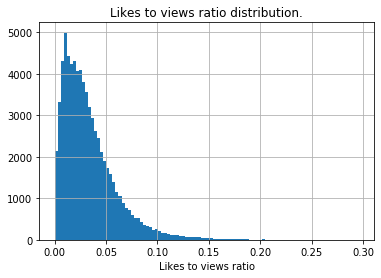

In [6]:
(df['likes']/df['views']).hist(bins=100)
plt.title("Likes to views ratio distribution.")
plt.xlabel('Likes to views ratio')
plt.show()

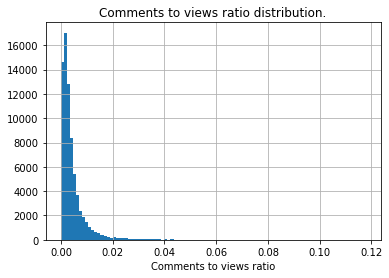

In [7]:
(df['comment_count']/df['views']).hist(bins=100)
plt.title("Comments to views ratio distribution.")
plt.xlabel('Comments to views ratio')
plt.show()

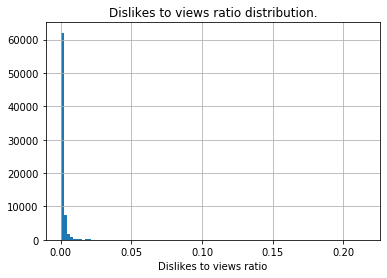

In [8]:
(df['dislikes']/df['views']).hist(bins=100)
plt.title("Dislikes to views ratio distribution.")
plt.xlabel('Dislikes to views ratio')
plt.show()

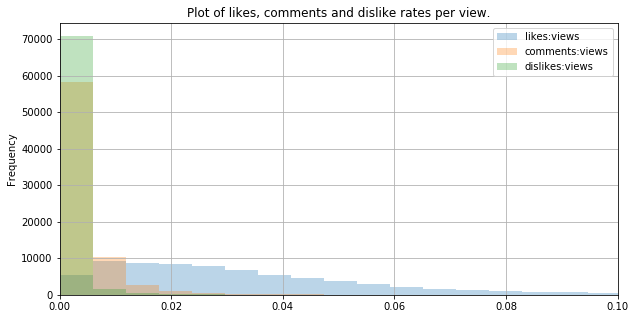

In [9]:
df_rates = pd.DataFrame({'likes:views': (df['likes']/df['views']).values, 'comments:views': (df['comment_count']/df['views']).values, 'dislikes:views':(df['dislikes']/df['views']).values}, columns=['likes:views', 'comments:views', 'dislikes:views'])

df_rates.plot.hist(alpha=0.3, bins=50, figsize=(10, 5), xlim = ([0, 0.10])).set_title("Plot of likes, comments and dislike rates per view.")
plt.grid()
plt.show()

### Aggregating the Data

In [10]:
# get a snapshot of video lifetime over its trending period

df_aff = df.groupby(['video_id']).agg(
    # views TRending Starts
    views_trs = pd.NamedAgg(column = 'views', aggfunc = 'first'),
    
    # views TRending Ends
    views_tre = pd.NamedAgg(column = 'views', aggfunc = 'last'),
    
    # same for likes, dislikes and comments
    likes_trs = pd.NamedAgg(column = 'likes', aggfunc = 'first'),
    likes_tre = pd.NamedAgg(column = 'likes', aggfunc = 'last'),
    dislk_trs = pd.NamedAgg(column = 'dislikes', aggfunc = 'first'),
    dislk_tre = pd.NamedAgg(column = 'dislikes', aggfunc = 'last'),
    comms_trs = pd.NamedAgg(column = 'comment_count', aggfunc = 'first'),
    comms_tre = pd.NamedAgg(column = 'comment_count', aggfunc = 'last'),
    
    # date it gets on trending
    trending_start = pd.NamedAgg(column = 'trending_date', aggfunc = min),
    trending_end = pd.NamedAgg(column = 'trending_date', aggfunc = max),
    # integer value of number of days on trending
    days_trending = pd.NamedAgg(column = 'trending_date', aggfunc = lambda d: (max(d) - min(d)).days)
)

### Basic Feature Engineering

In [11]:
# engineered features
df_aff['days_trending'] = (df_aff["trending_end"]-df_aff["trending_start"]).dt.days
df_aff['views_gain'] = df_aff["views_tre"]-df_aff["views_trs"]
df_aff['likes_gain'] = df_aff["likes_tre"]-df_aff["likes_trs"]
df_aff['dislk_gain'] = df_aff["dislk_tre"]-df_aff["dislk_trs"]
df_aff['comms_gain'] = df_aff['comms_tre'] - df_aff['comms_trs']
df_aff['likes_view'] = (df_aff["likes_gain"]/df_aff["views_gain"])/ df_aff['days_trending']

### Target Feature Definiton

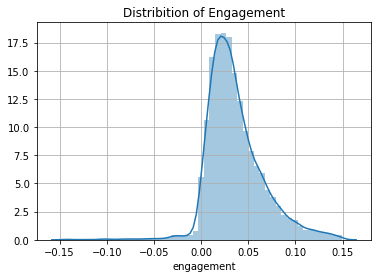

In [12]:
# engagement feature
# 5% target for likes:views ratio and 0.5% target for comments:views combined into one feature.

df_aff['engagement'] = (10*df_aff['comms_gain'] + df_aff['likes_gain'])/df_aff['views_gain']
df_aff = df_aff[(df_aff['engagement'] > -1) & (df_aff['engagement'] < 1)]

sns.distplot(df_aff[(df_aff['engagement'] > -0.15) & (df_aff['engagement'] < 0.15)]['engagement']).set_title("Distribition of Engagement")
plt.grid()
plt.show()

In [13]:
df_aff = df_aff.reset_index()

In [14]:
# pull additional columns into the new data set
df_all = df_aff.merge(df[['video_id','title', 'channel_title', 'category_id','publish_time', 'tags', 'description', 'thumbnail_link', 'views','likes', 'dislikes', 'comment_count']], how = 'right', on = 'video_id')
df_all = df_all.drop_duplicates(subset = 'video_id')

In [15]:
# drop columns with missing values originated from clipping engagement values
df_all = df_all.dropna()

## Relationship Between Category and Engagement

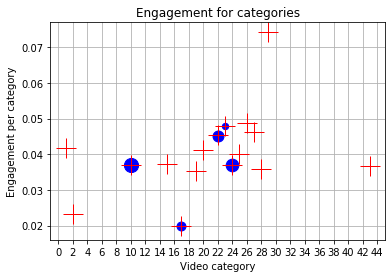

In [16]:
plt.plot(df_all.groupby(['category_id']).mean()['engagement'], '+', markersize = 20, color = 'red' )
plt.scatter(10, 0.037, marker = 'o', s = 200, color = 'blue')
plt.scatter(24, 0.037, marker = 'o', s = 160, color = 'blue')
plt.scatter(22, 0.045, marker = 'o', s = 120, color = 'blue')
plt.scatter(17, 0.02, marker = 'o', s = 80, color = 'blue')
plt.scatter(23, 0.048, marker = 'o', s = 40, color = 'blue')
plt.xticks(np.arange(0, 46, 2))
plt.grid()
plt.xlabel("Video category"); plt.ylabel("Engagement per category")
plt.title("Engagement for categories")
plt.show()

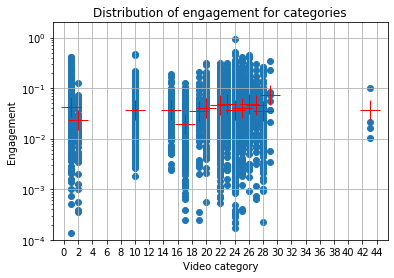

In [17]:
#g = sns.jointplot(df_all['letters_per_word'], df_all['views_gain'] )
#g.ax_joint.set_xscale('log'); #g.ax_joint.set_yscale('log')
plt.plot(df_all.groupby(['category_id']).mean()['engagement'], '+', markersize = 20, color = 'red' )
plt.xticks(np.arange(0, 46, 2))
plt.scatter(df_all['category_id'], df_all['engagement'])
#plt.scatter(df_all['category_id'], df_all.groupby(['category_id']).mean()['likes_view']  )
#plt.xscale('log'); 
plt.yscale('log'); 
plt.ylim([10**-4, 10**0.3]); 
plt.grid()
plt.xlabel("Video category"); plt.ylabel("Engagement")
plt.title("Distribution of engagement for categories")
plt.show()

### What features could we extract which are indicators of engagement?